# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [39]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class RangeDataset(torch.utils.data.Dataset):
    import torch.nn as nn
    def __init__(self, start, end, step=1):
        self.start = start
        self.end = end
        self.step = step

    def __len__(self):
        return math.ceil((self.end - self.start) / self.step)

    def __getitem__(self, index):
        value = self.start + index * self.step
        return value
    
    
#dataset = RangeDataset(0, 10)
#data_loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0, drop_last=True, pin_memory=True)



class RangeModel(nn.Module):
    def __init__(self):
        super(RangeModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


def log_rmse_loss(y_pred, y_true):
    mse_loss = F.mse_loss(y_pred, y_true)
    if mse_loss == 0:
        rmse_loss = torch.tensor(0.0)
    else:
        rmse_loss = torch.sqrt(mse_loss)
    log_rmse_loss = torch.log1p(rmse_loss)
    return log_rmse_loss
 

C:\Users\vmakh\AppData\Local\Temp\ipykernel_9124\2653712764.py:43: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(y_pred, y_true)


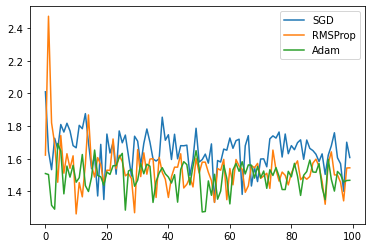

In [41]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Задаем seed для повторяемости результатов
random.seed(13)
np.random.seed(13)
torch.manual_seed(13)

# Создаем датасет и загрузчики данных
dataset = RangeDataset(0, 10)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.25, random_state=13)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0, drop_last=True, pin_memory=True)

# Создаем модель и определяем функцию потерь и оптимизаторы
model = RangeModel()
criterion = log_rmse_loss
sgd_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
rmsprop_optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Обучаем модель с SGD optimizer
sgd_losses = []
for epoch in range(100):
    running_loss = 0.0
    for inputs in train_loader:
        sgd_optimizer.zero_grad()
        outputs = model(inputs.float().unsqueeze(1))
        loss = criterion(outputs, inputs.float())
        loss.backward()
        sgd_optimizer.step()
        running_loss += loss.item()
    sgd_losses.append(running_loss / len(train_loader))

# Обучаем модель с RMSprop optimizer
rmsprop_losses = []
for epoch in range(100):
    running_loss = 0.0
    for inputs in train_loader:
        rmsprop_optimizer.zero_grad()
        outputs = model(inputs.float().unsqueeze(1))
        loss = criterion(outputs, inputs.float())
        loss.backward()
        rmsprop_optimizer.step()
        running_loss += loss.item()
    rmsprop_losses.append(running_loss / len(train_loader))

# Обучаем модель с Adam optimizer
adam_losses = []
for epoch in range(100):
    running_loss = 0.0
    for inputs in train_loader:
        adam_optimizer.zero_grad()
        outputs = model(inputs.float().unsqueeze(1))
        loss = criterion(outputs, inputs.float())
        loss.backward()
        adam_optimizer.step()
        running_loss += loss.item()
    adam_losses.append(running_loss / len(train_loader))

# Выводим результаты
import matplotlib.pyplot as plt

plt.plot(sgd_losses, label='SGD')
plt.plot(rmsprop_losses, label='RMSProp')
plt.plot(adam_losses, label='Adam')
plt.legend()
plt.show()


Как видно из графика, сходимость Adam и RMSProp лучше, чем у SGD, так как они достигают минимума функции потерь быстрее, чем SGD